In [51]:
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

# Proceso de creación de subgrafos

In [52]:
# Cargamos el grafo seleccionado
def load_graph(name_graph, graphs_folder):
    full_graph_path = graphs_folder + name_graph + ".gexf"
    # Cargamos el grafo
    G = nx.read_gexf(full_graph_path)
    print("Cargado el grafo de la hora " + name_graph.split('_')[-1] + ', numero de nodos: ' + str(G.number_of_nodes()) + ', numero de aristas: ' + str(G.number_of_edges()))
    return G

In [53]:
def add_nodes_subgraph(G, treshold):
    F = nx.Graph()
    for node in G.nodes():
        # Comprobamos si el grado del nodo es mayor que el umbral
        if G.degree[node] > treshold:
            # Añadimos el nodo
            F.add_node(node)
    return F

In [54]:
def add_edges_subgraph(G, F):
    for node in F.nodes():
        # Se itera sobre los vecinos en G de cada nodo y vemos si estan en F
        for neighbor in G.neighbors(node):
            if neighbor in F.nodes():
                # Se añade la arista si no existe ya
                if not neighbor in F.neighbors(node):
                    F.add_edge(node, neighbor)
    return F

In [55]:
def add_hidden_variable(F, avg_deg):
    dict_hidd_var = {}
    for node in F.nodes():
        dict_hidd_var[node] = F.degree[node] / avg_deg
    nx.set_node_attributes(F, dict_hidd_var, "internalDegree")

In [56]:
def calc_avg_degree(G):
    return sum(dict(G.degree).values())/G.number_of_nodes()

In [57]:
def tresh_normalization(G, treshold):

    # Añadimos solamente los nodos que cumplan el umbral
    F = add_nodes_subgraph(G, treshold)
    
    if F.number_of_nodes() == 0:
        return -1
    
    # Ahora añadimos las aristas de G de los nodos en el subgrafo F
    F = add_edges_subgraph(G, F)

    # Añadimos como variable oculta el grado entre la media del grafo a cada nodo
    avg_deg = calc_avg_degree(F)
    if avg_deg != 0:
        add_hidden_variable(F, avg_deg)
    else:
        return -1
    return F


In [70]:
def calc_fig2a(G, clust):
    dict_hid_var_aux = {}
    dict_hid_var = {}
    for node in G.nodes():
        att = G.nodes[node]["internalDegree"]
        if att in dict_hid_var_aux.keys():
            np.append(dict_hid_var_aux[att], clust[node])
        else:
            dict_hid_var_aux[att] = np.array(clust[node])
    dict_hid_var_aux_2 = {k: dict_hid_var_aux[k] for k in sorted(dict_hid_var_aux)}
    for key in dict_hid_var_aux_2.keys():
        dict_hid_var[key] = np.average(dict_hid_var_aux_2[key])

    return dict_hid_var

In [59]:
def calc_clust(G, MAX_UMBRAL):
    dict_tres_avg_clust = {}
    arr_2a = []
    for i in tqdm(range(MAX_UMBRAL)):
        treshold = i
        # Creamos el subgrafo basándonos en el treshold seleccionado
        F = tresh_normalization(G, treshold)
        if F == -1:
            # Caso de grafo vacío o grafo inconexo
            return dict_tres_avg_clust, arr_2a
        #TODO para ejecutar sobre gráfica cugraph https://github.com/rapidsai/cugraph/tree/branch-24.06/python/nx-cugraph
        clust  = nx.clustering(F)
        avg_clust = np.mean(np.array(list(clust.values())))
        #print("Cargado el subgrafo con umbral " + str(treshold) + ', numero de nodos: ' + str(F.number_of_nodes()) + ', numero de aristas: ' + str(F.number_of_edges()) + ', clusterizacion media: ' + str(avg_clust))
        dict_tres_avg_clust[treshold] = avg_clust

        arr_2a.append(calc_fig2a(F, clust))


    return dict_tres_avg_clust, arr_2a

In [60]:
def plot_clust(dict_tres, name_graph, plots_folder):
    # Obtener las claves y los valores del diccionario
    claves = list(dict_tres.keys())
    valores = list(dict_tres.values())

    plt.figure(figsize=(14,7)) 
    plt.xlabel('K_T')
    plt.ylabel('average c(KT)')

    plt.scatter(claves, valores, s=1, marker="x")
    print(plots_folder + name_graph.split('_')[-1])
    plt.savefig(plots_folder + name_graph.split('_')[-1])
    plt.show()

In [61]:
def calc_plot(name_graph, MAX_UMBRAL, graphs_folder, plots_folder):
    G = load_graph(name_graph, graphs_folder)
    dict_tres_avg_clust, arr_2a = calc_clust(G, MAX_UMBRAL)
    return arr_2a
    # Fig 2e
    plot_clust(dict_tres_avg_clust, name_graph, plots_folder)

    # Fig 2a
    plot_2a(arr_2a, name_graph, plots_folder)

In [62]:
def get_paths(MODE, MANIFESTACION, metric="correlation"):
    graphs_folder = "graphs/"
    plots_folder = "plots/" + metric + '/'

    modes_folder = "nodes_" + MODE + '/'
    graphs_folder = graphs_folder + modes_folder + MANIFESTACION + '/'
    plots_folder = plots_folder + modes_folder + MANIFESTACION + '/'
    return  graphs_folder, plots_folder

In [71]:

# Seleccionamos el modo con el que queremos crear nuestra red: Hashtags como nodos o usuarios como nodos
#MODE = "user"
MODE = "hashtag"

# MAX_UMBRAL es el máximo K_T que vamos a usar para generar subgrafos
MAX_UMBRAL = 600

# Seleccionamos el fichero correspondiente a la manifestación social de la que queremos sacar la red y seleccionamos la hora que queremos estudiar
#MANIFESTACION = "9n"

MANIFESTACION = "nat"
# Hora critica NaT
hora = "429624"

#MANIFESTACION = "9n"
# Hora critica 9n
#hora = "437038"

graphs_folder, plots_folder = get_paths(MODE, MANIFESTACION, metric="correlation")

arr_2a = calc_plot(hora, MAX_UMBRAL, graphs_folder, plots_folder)

Cargado el grafo de la hora 429624, numero de nodos: 8131, numero de aristas: 38437


 90%|█████████ | 541/600 [00:45<00:04, 11.97it/s]


In [81]:
def plot_2a(arr_2a, name_graph, plots_folder):

    #print(len(arr_2a))
    arr_index = [5, 10, 20, 50, 100, 150, 200, 250]
    #arr_index = [5, 50, 100]
    markers = [".", "o", "v", "<", ">", "s", "p", "*"]
    # Crea el histograma
    plt.xscale('log')  
    plt.yscale('log')      
    for i, index in enumerate(arr_index):
        points_x = arr_2a[index].keys()
        points_y = arr_2a[index].values()
        print(points_x)
        print(points_y)
        plt.plot(points_x, points_y, alpha=1)
    plt.legend(arr_index)
    plt.savefig(plots_folder + name_graph.split('_')[-1][:-4] + "2a.png")
    plt.show()

dict_keys([0.0, 0.04989521199419636, 0.09979042398839272, 0.14968563598258908, 0.19958084797678544, 0.2494760599709818, 0.29937127196517815, 0.34926648395937454, 0.39916169595357087, 0.44905690794776726, 0.4989521199419636, 0.54884733193616, 0.5987425439303563, 0.6486377559245526, 0.6985329679187491, 0.7484281799129454, 0.7983233919071417, 0.8482186039013381, 0.8981138158955345, 0.9480090278897308, 0.9979042398839272, 1.0477994518781235, 1.09769466387232, 1.1475898758665162, 1.1974850878607126, 1.247380299854909, 1.2972755118491053, 1.3471707238433017, 1.3970659358374982, 1.4469611478316944, 1.4968563598258908, 1.546751571820087, 1.5966467838142835, 1.64654199580848, 1.6964372078026762, 1.7463324197968726, 1.796227631791069, 1.8461228437852653, 1.8960180557794617, 1.945913267773658, 1.9958084797678544, 2.045703691762051, 2.095598903756247, 2.1454941157504432, 2.19538932774464, 2.245284539738836, 2.2951797517330323, 2.345074963727229, 2.3949701757214252, 2.4448653877156215, 2.4947605997

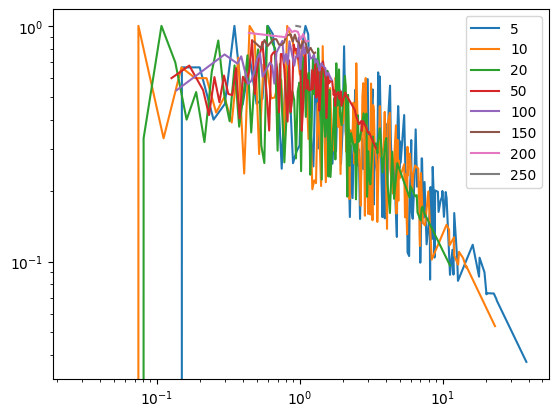

In [82]:
plot_2a(arr_2a, hora, plots_folder)

# Distribución de grados

In [ ]:
def normalize_dict(dict_dd, param_normalize):
    for key in dict_dd:
        dict_dd[key] /= param_normalize

In [ ]:
def calc_dist_degree(G):
    dict_dd = {}
    for _, deg in G.degree:
        if deg in dict_dd.keys():
            dict_dd[deg] +=1
        else:
            dict_dd[deg] = 1
    
    normalize_dict(dict_dd, G.number_of_nodes())
    return dict(sorted(dict_dd.items()))

In [ ]:
def plot_bar(x_axis, y_axis, name_x, name_y, name_plot, path, bin_log=True):
    # Crea el histograma
    plt.bar(x_axis, y_axis, alpha=0.7)
    plt.xlabel(name_x)
    plt.ylabel(name_y)
    plt.title(name_plot)
    if bin_log:
        plt.xscale('log')  
        plt.yscale('log')  
    plt.savefig(path)
    plt.show()

In [ ]:
def plot_bar_degree_distribution(dict_dd, name_graph, plots_folder):
    degrees = list(dict_dd.keys())
    num_nodes = list(dict_dd.values())
    
    plot_bar(degrees, num_nodes, "Degree", "Frequency", "Degree of nodes", plots_folder + name_graph + ".png", bin_log=True)

In [ ]:
def plot_bar_degree_distribution_cummulative(dict_dd, name_graph, plots_folder):
    # Obtén las claves (grados) y los valores (número de nodos) del diccionario
    degrees = list(dict_dd.keys())
    num_nodes = list(dict_dd.values())

    # Calcula la frecuencia acumulada
    cum_freq = np.cumsum(num_nodes)

    plot_bar(degrees, cum_freq, "Degree", "Cummlative frequency", "Degree of nodes (Cummulative)", plots_folder + name_graph + "_cummulative.png", bin_log=True)


In [ ]:
def plot_bar_degree_distribution_cummulative_complementary(diccionario, name_graph, plots_folder):
    # Obtén las claves (grados) y los valores (número de nodos) del diccionario
    degrees = list(diccionario.keys())
    num_nodes = list(diccionario.values())

    # Calcula la frecuencia acumulada
    cum_freq = np.cumsum(num_nodes)

    # Calcula la distribución complementaria a la acumulada
    comp_dist = np.array([cum_freq[-1]]) - cum_freq

    plot_bar(degrees, comp_dist, "Degree", "Complementary Cummlative frequency", "Degree of nodes (Complementary Cummulative)", plots_folder + name_graph + "_complementary_cummulative.png", bin_log=True)

In [ ]:
def plot_histogram(points, name_x, name_y, name_plot, path, bin_log=True):
    # Crea el histograma
    if bin_log:
        plt.xscale('log')  
        plt.yscale('log')         
        plt.hist(points, bins=np.logspace(np.log10(0.001), np.log10(1), 100))
    else:
        plt.hist(points, bins=100)

    plt.xlabel(name_x)
    plt.ylabel(name_y)
    plt.title(name_plot)

    plt.savefig(path)
    plt.show()

In [ ]:
def plot_scatter(points_x, points_y, name_x, name_y, name_plot, path, bin_log=False):
    # Crea el histograma
    if bin_log:
        plt.xscale('log')  
        plt.yscale('log')      

    plt.scatter(points_x, points_y, marker="x", s=1, alpha=0.7)

    plt.xlabel(name_x)
    plt.ylabel(name_y)
    plt.title(name_plot)

    plt.savefig(path)
    plt.show()

In [ ]:
def calc_plot_degree_distribution(name_graph, graphs_folder, plots_folder):
    G = load_graph(name_graph, graphs_folder)
    """dict_dd = calc_dist_degree(G)
    plot_bar_degree_distribution(dict_dd, name_graph, plots_folder,)
    plot_bar_degree_distribution_cummulative(dict_dd, name_graph, plots_folder)
    plot_bar_degree_distribution_cummulative_complementary(dict_dd, name_graph, plots_folder)"""

    # Normalizamos entre el número total de nodos
    points = np.sort(np.array(list(dict(G.degree()).values())).astype(float)/float(G.number_of_nodes()))
    plot_histogram(points, "Degree", "Frequency", "Degree of nodes", plots_folder + "hist_" + name_graph + ".png", bin_log=True)
    
    cum_freq = np.cumsum(points)
    cdf = cum_freq/cum_freq[-1]
    plot_scatter(points, cdf, "Degree/num_nodos)", "Cummlative frequency", "CDF - P(X<x)", plots_folder + "hist_" + name_graph + "_cummulative.png", bin_log=False)
    
    ccdf = 1 - cdf
    plot_scatter(points, ccdf, "Degree /(num nodos)", "Complementary Cummlative frequency", "CCDF - P(X>x)", plots_folder + "hist_" + name_graph + "_complementary_cummulative.png", bin_log=False)

Cargado el grafo de la hora 437038, numero de nodos: 5759, numero de aristas: 74354


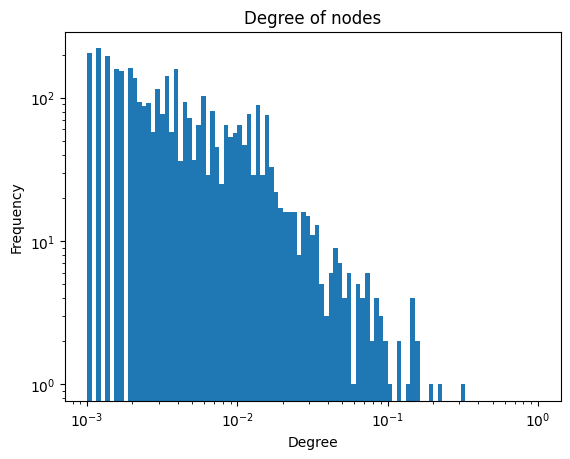

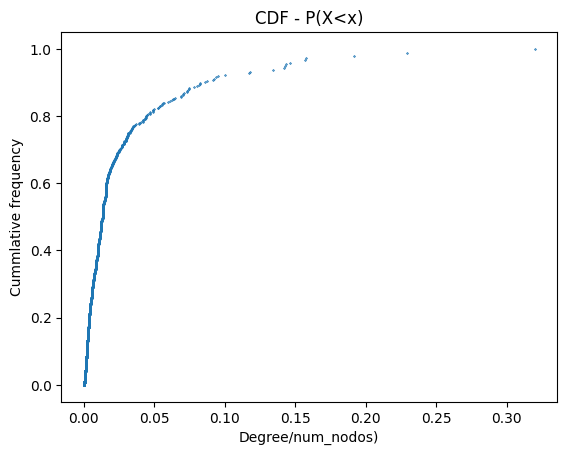

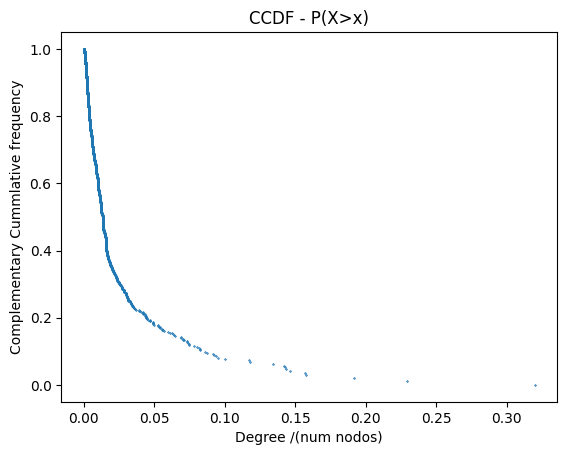

In [ ]:
MODE = "hashtag"

#MANIFESTACION = "nat"
#hora = "429624"

MANIFESTACION = "9n"
hora = "437038"


graphs_folder, plots_folder = get_paths(MODE, MANIFESTACION, metric="degree")

calc_plot_degree_distribution(hora, graphs_folder, plots_folder)


In [ ]:
for root, dirs, files in os.walk(graphs_folder, topdown=False):
    for name in files:
        if name.endswith(".gexf"):
            if not os.path.exists("plots/" + name.split("_")[-1][:-5] + ".png"):
                calc_plot(name[:-5])
            
# Selecciono el grafo de la hora que nos interesa
#name_graph = "hashtags_sharing_users_437036"
# 437037 se corresponde con las 21:00 del 9n (momento explosion segun paper Yerali)
#calc_plot(name_graph)

TypeError: calc_plot() missing 3 required positional arguments: 'MAX_UMBRAL', 'graphs_folder', and 'plots_folder'

In [ ]:
#H = tresh_normalization(G, 1)
#A graph is commonly classified as small-world if sigma>1.
sigma = nx.smallworld.sigma(G)
print("a")
# Values close to 0 mean that G has small-world characteristics.
omega = nx.smallworld.omega(G)

print("sigma: ", sigma, ", omega: ", omega)